In [1]:
import os
import numpy as np

import torch
from torch.utils.data import DataLoader

from segment.data import AAPM
from segment.data.utils import train_valid_split

import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
PATH = '/home/ygx/data/aapm17/permuted'
OUTPATH = '/home/ygx/data/aapm17/processed'

In [3]:
aapm = AAPM(PATH)

In [4]:
loader = DataLoader(aapm, 1)

In [6]:
imgs = []
all_masks = []
for idx, (img, mask) in enumerate(loader):
    if idx % 10 == 0:
        print(f'Image: {img.shape}, Masks: {mask.shape}')
    imgs.append(img)
    all_masks.append(mask)

Image: torch.Size([1, 122, 512, 512]), Masks: torch.Size([1, 122, 512, 512])
Image: torch.Size([1, 133, 512, 512]), Masks: torch.Size([1, 133, 512, 512])
Image: torch.Size([1, 148, 512, 512]), Masks: torch.Size([1, 148, 512, 512])
Image: torch.Size([1, 204, 512, 512]), Masks: torch.Size([1, 204, 512, 512])


In [7]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    img = ax.imshow(volume[ax.index])
    fig.colorbar(img)
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [8]:
for i in range(len(imgs)):
    all_masks[i] = all_masks[i].squeeze(0)
    imgs[i] = imgs[i].squeeze(0)

<IPython.core.display.Javascript object>


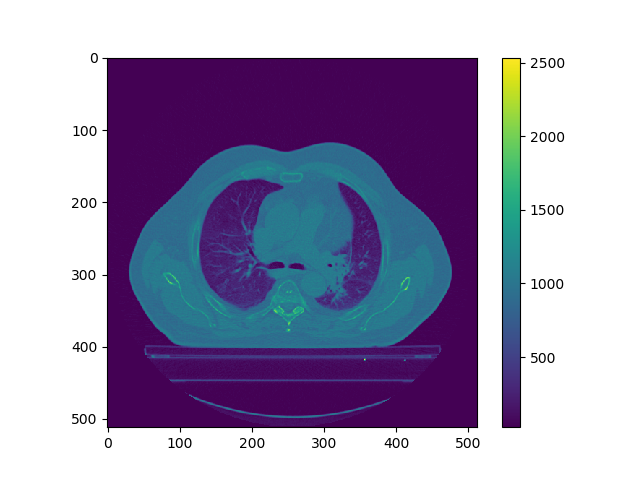

In [11]:
multi_slice_viewer(imgs[0])

<IPython.core.display.Javascript object>


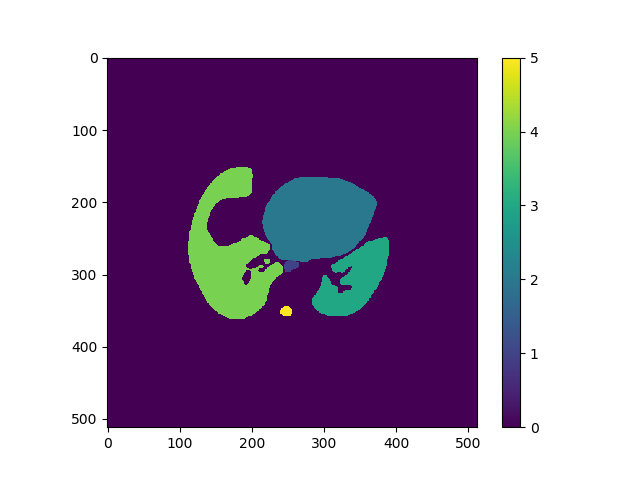

In [40]:
# Gold standard mapping
gold = all_masks[0]
multi_slice_viewer(gold)

<IPython.core.display.Javascript object>


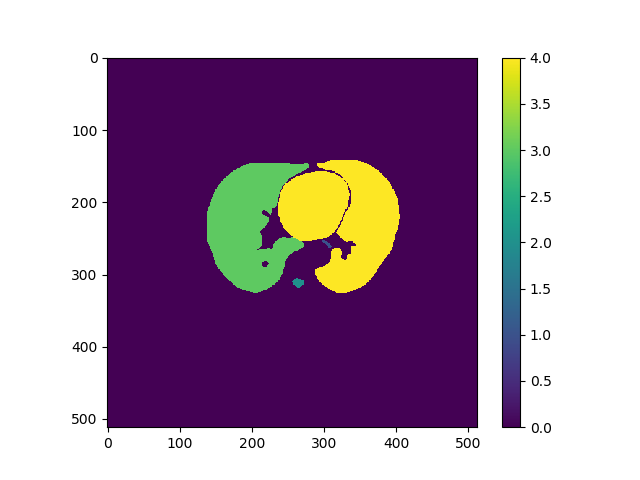

In [45]:
multi_slice_viewer(get_patient(6))

In [17]:
def remap(img, dictionary, patient_number, path=OUTPATH):
    """
    Parameters
    ----------
    img : tensor (S,H,W)
    
    dictionary : {original_label: correct_label} [{int: int}]
    """
    img = img.numpy()
    labs = np.zeros_like(img, dtype=np.uint8)
    
    for obs, cor in dictionary.items():
        labs += cor*(img == obs).astype(np.uint8)
        
    labs = torch.tensor(labs)
        
    filename = f'label_{patient_number}.pth'
    filepath = os.path.join(path, filename)
    torch.save(labs, filepath)
    
    return labs

In [22]:
def get_patient(patient_number, masks=all_masks):
    return masks[patient_number]

## Patient 15

In [18]:
patient15_origmasks = all_masks[15]
dict15 = {0:0, 1:4, 2:3, 3:5, 4:2, 5:1}

In [19]:
patient15_newmasks = remap(patient15_origmasks, dict15, 15)

In [32]:
#multi_slice_viewer(patient15_origmasks)

In [31]:
#multi_slice_viewer(patient15_newmasks)

In [30]:
#multi_slice_viewer(all_masks[0])

## Patient 2

In [26]:
pat2_orig = get_patient(2)
pat2_dict = {0:0, 1:5, 2:4, 3:3, 4:2, 5:1}
pat2_new = remap(pat2_orig, pat2_dict, 2)

In [29]:
#multi_slice_viewer(pat2_orig)

In [28]:
#multi_slice_viewer(pat2_new)

## Patient 5

In [39]:
pat5_orig = get_patient(5)
pat5_dict = {0:0, 1:1, 2:2, 3:5, 4:3, 5:4}
pat5_new = remap(pat5_orig, pat5_dict, 5)

In [43]:
#multi_slice_viewer(gold)

In [44]:
#multi_slice_viewer(pat5_new)